# Exploratory Data Analysis


## 1. Setup


### 1.1 Imports


In [1]:
from scripts.data_loader import load_data, split_features_targets
from scripts.preprocessor import remove_fillers, set_types, fill_missing, transform_data
from scripts.feature_analysis import (
    save_plots,
    plot_group_histogram,
    plot_group_boxplot,
    plot_group_line_chart,
    plot_group_spatial_heatmap,
)

### 1.2 Loading Dataset


In [2]:
# Load data into DataFrames.
df = load_data("data")
df = remove_fillers(df)
df = fill_missing(df, "mean")
df = transform_data(df)
df = set_types(
    df,
    {
        "x": int,
        "y": int,
        "year": int,
        "ice_mask": int,
    },
)
print(f"📊 Data: \n {df.head()}\n")
features, targets = split_features_targets(df)
variables = [
    "air_temperature",
    "ocean_temperature",
    "precipitation",
    "ice_thickness",
    "ice_mask",
    "ice_velocity",
]
boundary_conditions = ["precipitation", "air_temperature", "ocean_temperature"]

📊 Data: 
      x   y  ice_thickness  ...  air_temperature  ocean_temperature  year
14 -11  25            0.0  ...         0.836595          -0.034495  2015
15 -10  25            0.0  ...         0.830760          -0.079245  2015
16  -9  25            0.0  ...         0.825038          -0.114335  2015
17  -8  25            0.0  ...         0.819387          -0.139854  2015
18  -7  25            0.0  ...         0.814295          -0.157410  2015

[5 rows x 9 columns]



c:\Users\samma\OneDrive\Documents\GitHub\SeaLevelAI\scripts\preprocessor.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].fillna(-1)
c:\Users\samma\OneDrive\Documents\GitHub\SeaLevelAI\scripts\preprocessor.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ice_mask"] = df["ice_mask"].fillna(4)
c:\Users\samma\OneDrive\Documents\GitHub\SeaLevelAI\scripts\preprocessor.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

## 2. Feature Space


In [ ]:
for feature in variables:
    save_plots(df, f"out/images/{feature}", feature)

### 2.0 Data Descriptions


In [3]:
# Describe the data.
print(f"📊 Data description: \n {df.describe()}\n")

📊 Data description: 
                  x            y  ...  ocean_temperature           year
count  194102.0000  194102.0000  ...      194102.000000  194102.000000
mean        0.0000       0.0000  ...           0.166677    2057.500000
std        13.4209      13.4209  ...           0.789064      24.824447
min       -25.0000     -25.0000  ...          -1.228246    2015.000000
25%       -11.0000     -11.0000  ...          -0.419754    2036.000000
50%         0.0000       0.0000  ...           0.000000    2057.500000
75%        11.0000      11.0000  ...           0.580246    2079.000000
max        25.0000      25.0000  ...           3.679689    2100.000000

[8 rows x 9 columns]



### 2.1 NaN Values


In [ ]:
# Plot NaN values in each column
NaN_values = df.isna().sum()
sns.barplot(x=NaN_values.index, y=NaN_values.values)
plt.xticks(rotation=90)
plt.title("NaN values per column")
plt.xlabel("Columns")
plt.ylabel("NaN values")
plt.show()

print(f"📊 NaN values per column: \n {df.isna().sum()}\n")

# calculate each columns proportion of NaN values
NaN_proportion = df.isna().sum() / len(df)
print(f"📊 NaN values proportion per column: \n {NaN_proportion}\n")

# Plot a heatmap of NaN values
plot_spatial_heatmap(df, "ocean_temperature")

### 2.2 Outliers


In [ ]:
plot_group_boxplot(df, variables, 2, 3)

### 2.3 Duplicates


In [ ]:
print(f"📊 Duplicates: {df.duplicated().sum()}")

### 2.4 Univariate Analysis


In [ ]:
plot_group_histogram(df, variables, 2, 3)

### 2.5 Static Spatial Representations


In [ ]:
plot_group_spatial_heatmap(df, variables, 2, 3)

In [ ]:
for column in boundary_conditions:
    plot_spatial_heatmap(df, column)

In [ ]:
for column in targets.columns:
    plot_spatial_heatmap(df, column)

### 2.6 Dynamic Spatial Representations


In [ ]:
for column in boundary_conditions:
    create_heatmap_gif(df, column)

In [ ]:
for column in targets.columns:
    create_heatmap_gif(df, column)

### 2.7 Temporal Representations


In [ ]:
plot_group_line_chart(df, variables, 2, 3)

In [ ]:
for feature in boundary_conditions:
    plot_line(df, feature)

In [ ]:
for target in targets.columns:
    plot_line(df, target)

## 3. Correlation Analysis


In [ ]:
# Plot a correlation matrix
corr = df[variables].corr()
sns.heatmap(corr, annot=True, cmap="YlGnBu")
plt.title("Correlation matrix")
plt.show()

## 3. Feature Engineering


### 3.2 Feature Creation


In [3]:
created_features = []

# Distance to Pole
df["dtp"] = np.sqrt(df["x"] ** 2 + df["y"] ** 2)
created_features.append("dtp")

# Rolling Standard Deviation
for feature in ["precipitation", "air_temperature"]:
    df[f"{feature}_rolling_std"] = df[feature].rolling(window=3).std()
    created_features.extend([f"{feature}_rolling_std"])

# Difference of ocean_temperature and air_temperature
df["temp_diff"] = df["air_temperature"] - df["ocean_temperature"]
created_features.append("temp_diff")

# Log Transformation of air_temperature
df["log_air_temperature"] = np.log(df["air_temperature"] + 1)
created_features.append("log_air_temperature")

### 3.3 Created Feature Analysis


          dtp  precipitation_rolling_std  air_temperature_rolling_std  \
14  27.313001                        NaN                          NaN   
15  26.925824                        NaN                          NaN   
16  26.570661                   0.023983                     0.005778   
17  26.248809                   0.013944                     0.005687   
18  25.961510                   0.010065                     0.005374   

    temp_diff  log_air_temperature  
14   0.871089             0.607913  
15   0.910005             0.604731  
16   0.939374             0.601601  
17   0.959240             0.598499  
18   0.971705             0.595697  


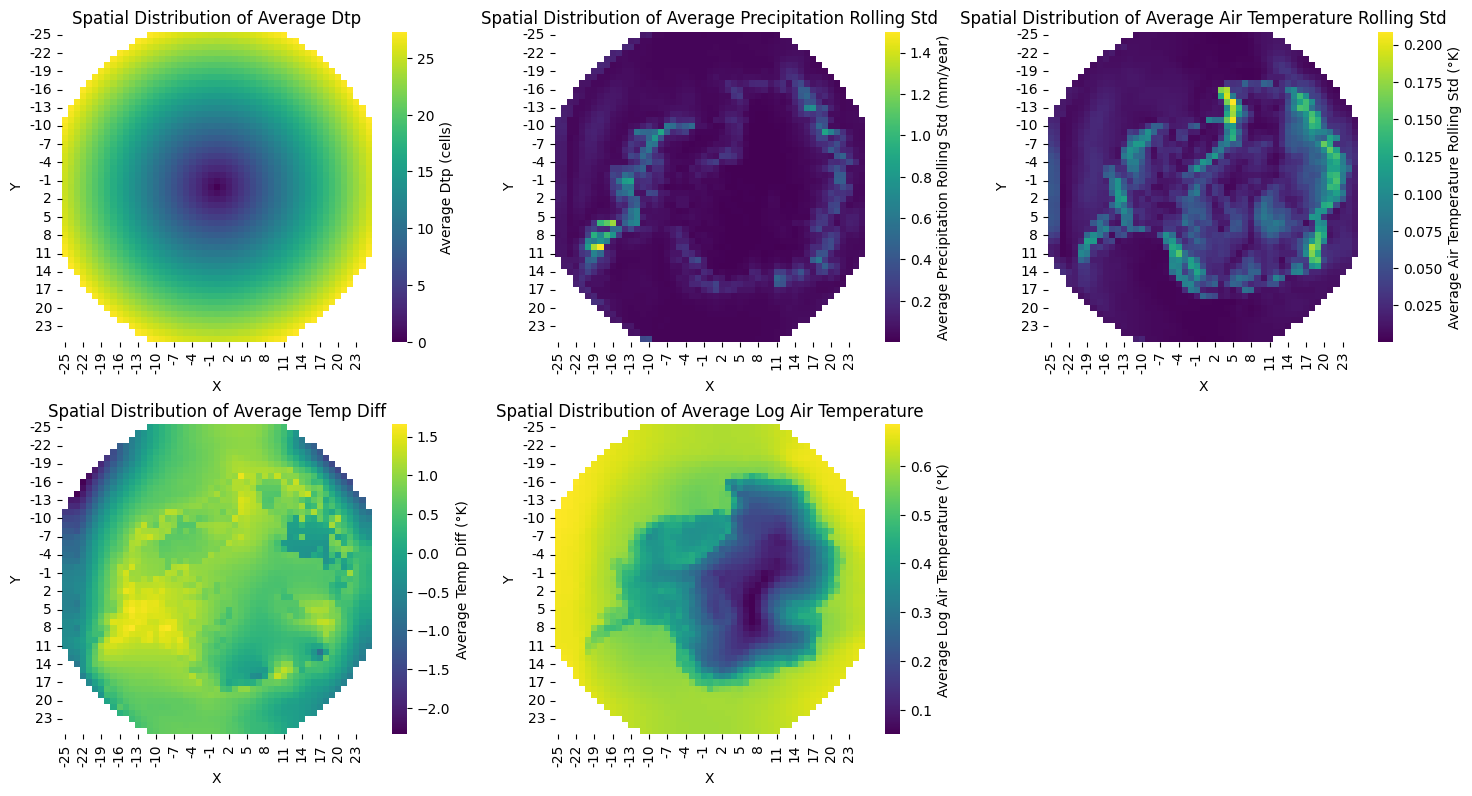

In [4]:
df_created = df[created_features]
print(df_created.head())

plot_group_spatial_heatmap(df, created_features, 2, 3)

### 3.4 Created Feature Correlation Analysis


In [ ]:
created_with_targets = created_features + targets.columns.tolist()
corr = df[created_with_targets].corr()
plt.figure(figsize=(15, 15))
sns.heatmap(corr, annot=True, cmap="YlGnBu")
plt.title("Correlation matrix of Created Features with Targets")
plt.show()